<a href="https://colab.research.google.com/github/vsolodkyi/NeuralNetworks_SkillBox/blob/main/other_courses/homework_2_last_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание

В этом домашнем задании перед вами стоит задача научиться по фотографии лица человека предсказывать его пол, расу и возраст.

[Датасет](https://susanqq.github.io/UTKFace/), который мы будем использовать состоит из 20000 фотографий лиц людей в возрасте от 0 до 116 лет! В качестве разметки имеется пол (male/female), раса (white/black/asian/indian/other) и возраст. Классификация с настолько сильной внутриклассовой изменьчивостью (от младенцев до пожилых людей!) -- очень сложная задача. 
![alt text](https://susanqq.github.io/UTKFace/icon/samples.png)

Мы немного упростим себе задачу и воспользуемся версией датасета, где все картинки приведены к одному размеру и лица находятся в центре изображения.

Как решать такую задачу? Мы предлагаем вам воспользоваться **transfer learning и finetuning**. Т.е. взять за основу сеть, обученную на большом количестве данных для другой задачи и дообучить ее для нашей задачи.

*Это достаточно объемное и сложное домашнее задание, но не пугайтесь --  вы уже обладаете всеми знаниями, которые необходимы для его решения. Отметим, что уметь дообучить сеть является необходимим навыком на практике.*

## Задание 1

Датасетом, с которого чаще всего "переносят" знания, является известный нам ImageNet. Работая над классификатором кошек и собак на прошлом уроке мы воспользовались именно им. В этом задании мы возьмем за основу сеть, которая была обучена на датасете [VGGFace2](http://www.robots.ox.ac.uk/~vgg/data/vgg_face2/) для классификации лиц. Он содержит 3.3 миллиона изображений с 9000 разными персоналиями. **Почему мы сделали выбор в пользу VGGFace2?**

**ВПИШИТЕ ОТВЕТ ЗДЕСЬ**

**-----**

Нам не нужна модель, различающая мач от автомобиля или попугая. Работая с лицами, нам могут потредоваться другие признаки. Поэтому модель, обученная на лицах, больше подходит для наших целей.

*Возможный ответ: Датасет VGGFace2 гораздо ближе к нашей задаче. Значит, признаки которые он научился извлекать из изображений будут нам горазддо полезне и помогут обучить модель лучше и быстрее*

**-----**




А теперь перейдем к практической части домашнего задания. Для начала загрузим модель, которую будем дообучать -- это мы сделали за вас. Пожалуйста, просмотрите код и комментарии внимательно.

## Загрузка обученной модели

Сеть, которую мы будем дообучать мы возьмем из открытого источника: https://github.com/rcmalli/keras-vggface .

In [ ]:
! pip install git+https://github.com/rcmalli/keras-vggface.git

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-d669_xg4
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-d669_xg4
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=c5783b2bb133ed77edbfeba426c3d49aa6a4507eda328ea3cd8e57c9a50f7f23
  Stored in directory: /tmp/pip-ephem-wheel-cache-cp8rcwhu/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [ ]:
#$%tensorflow_version 1.x
import tensorflow as tf
#tf.enable_eager_execution()
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Т.к. мы решили воспользоваться чужой моделью, нам нужно сначала понять как с ней взаимодействовать. Для этого авторы часто прикладывают пример использования своих моделей. Его можно найти в README у автора репозитория.

In [ ]:
# код из https://github.com/rcmalli/keras-vggface/blob/master/README.md
# при выполнении вызовет ошибку -- это нормально
!pip install keras_applications

from keras_vggface.vggface import VGGFace

vggface_model = VGGFace(model='resnet50') # or VGGFace() as default

     |████████████████████████████████| 51kB 4.4MB/s 
165445632/165439116 [==============================] - 4s 0us/step


Ошибка появляется потому что, пример из репозитория не использует режим eager_execution, который мы всегда включали в своих примерах для удобства разработки и соответствия новым стандартам tensorflow. 

Но это не проблема. Мы за вас заранее выполнили код выше без eager_execution и сохранили модель с помощью save_model. Она находится по адресу: https://drive.google.com/open?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO . Загрузим модель:


In [ ]:
! pip install gdown
import gdown

# url = 'https://drive.google.com/uc?id=1oHJxVZCcVwp1dgcwDIZL4h97uInxOGWO'
# output = 'resnet50face.h5'
# gdown.download(url, output, quiet=False)

In [ ]:
from tensorflow.keras.models import load_model
# vggface_model = load_model("resnet50face.h5")

Модель загружена, а теперь посмотрим, что она из себя представляет. Это архитектура -- ResNet. На самом деле внутренности модели не очень важны для нас -- в дальнейшем мы заморозим бОльшую часть этой сети и будем рабоать только с последними слоями. Нам важно, что она обучена и мы имеем доступ к ее архитектуре и весам.

In [ ]:
vggface_model = VGGFace(model='resnet50')

In [ ]:
vggface_model.summary() # последний слой классифицирует на 8631 классов

Model: "vggface_resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)           (None, 112, 112, 64) 9408        input_2[0][0]                    
__________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormaliza (None, 112, 112, 64) 256         conv1/7x7_s2[0][0]               
__________________________________________________________________________________________________
activation_49 (Activation)      (None, 112, 112, 64) 0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________

Для проверки того, что помимо архитектуры мы правильно загрузили веса, проверим предсказания модели на следующем изображении: 

In [ ]:
! wget https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg -O brad_pitt.jpg

--2020-12-09 09:38:04--  https://img.joinfo.ua/i/2019/01/5c4ea940d2b08.jpg
Resolving img.joinfo.ua (img.joinfo.ua)... 104.26.7.169, 104.26.6.169, 172.67.74.175, ...
Connecting to img.joinfo.ua (img.joinfo.ua)|104.26.7.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 41064 (40K) [image/jpeg]
Saving to: ‘brad_pitt.jpg’

brad_pitt.jpg       100%[===================>]  40.10K  --.-KB/s    in 0s      

2020-12-09 09:38:04 (169 MB/s) - ‘brad_pitt.jpg’ saved [41064/41064]



После загрузки запустим полный пример из репозитория:

1351680/1346516 [==============================] - 0s 0us/step


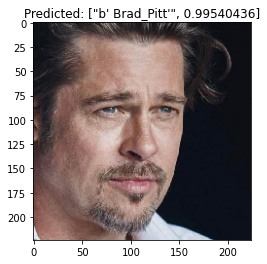

In [ ]:
from keras_vggface import utils
from tensorflow.keras.preprocessing import image

img = image.load_img("brad_pitt.jpg", target_size=(224, 224)) # модель работает с картинками размера 224 на 224
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) # мы используем resnet50 -- поэтому version2. Эта функция нам еще пригодится!

preds = vggface_model.predict(x) # модель -- известная нам keras model, вызываем predict
plt.title(f"Predicted: {utils.decode_predictions(preds)[0][0]}") # используем  decode_predictions из keras_vggface
plt.imshow(img)

## Загрузка данных
Мы убедились, что модель загружена правильно, узнали какой препроцессинг ей необходим (utils.preprocess_input(x, version=2)) и теперь можем перейти к загрузке наших данных.

In [ ]:
from pathlib import Path
from collections import Counter

In [ ]:
url = 'https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk'
output = '/tmp/UTKFace.tar.gz'
gdown.download(url, output, quiet=False)
! tar -xzf /tmp/UTKFace.tar.gz -C /tmp/
url = 'https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2'
output = 'train_val_split_utk.csv'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0BxYys69jI14kYVM3aVhKS1VhRUk
To: /tmp/UTKFace.tar.gz
107MB [00:01, 84.3MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1mux7xiP4NP6AUUFvUW42RgSdUEQ4k5e2
To: /content/train_val_split_utk.csv
100%|██████████| 1.08M/1.08M [00:00<00:00, 127MB/s]


'train_val_split_utk.csv'

In [ ]:
data_folder = Path("/tmp/UTKFace/")
filenames = list(map(lambda x: x.name, data_folder.glob('*.jpg')))
print(len(filenames))
print(filenames[:3]) # имя файла содержит возраст, индекс пола и расы, перечисленные через нижнее подчеркивание

23708
['27_1_4_20170103234931350.jpg.chip.jpg', '75_1_0_20170120230326690.jpg.chip.jpg', '35_0_3_20170117190400401.jpg.chip.jpg']


In [ ]:
# формируем датафрейм с путями и нужными классами
np.random.seed(10)
np.random.shuffle(filenames)
gender_mapping = {0: 'Male', 1: 'Female'}
race_mapping = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))
age_labels, gender_labels, race_labels, correct_filenames = [], [], [], []

for filename in filenames:
    if len(filename.split('_')) != 4:
        print(f"Bad filename {filename}")
        continue

    age, gender, race, _ = filename.split('_')
    correct_filenames.append(filename)
    age_labels.append(age)
    gender_labels.append(gender)
    race_labels.append(race)
    
age_labels = np.array(age_labels, dtype=np.float32)
max_age = age_labels.max()
data = {"img_name": correct_filenames, 
        "age": age_labels / max_age, # нормализуем возраст от 0 до 1
        "race": race_labels, 
        "gender": gender_labels}
df = pd.DataFrame(data)
df.head()

Bad filename 61_1_20170109142408075.jpg.chip.jpg
Bad filename 61_1_20170109150557335.jpg.chip.jpg
Bad filename 39_1_20170116174525125.jpg.chip.jpg


,img_name,age,race,gender
0,24_0_3_20170104230150057.jpg.chip.jpg,0.206897,3,0
1,23_1_4_20170103223903439.jpg.chip.jpg,0.198276,4,1
2,32_0_3_20170117182326773.jpg.chip.jpg,0.275862,3,0
3,23_0_0_20170113210126449.jpg.chip.jpg,0.198276,0,0
4,52_0_0_20170105173217669.jpg.chip.jpg,0.448276,0,0


In [ ]:
df_split = pd.read_csv("train_val_split_utk.csv", index_col=0).set_index("img_name")
df_split.head()
df = df.set_index("img_name").join(df_split).reset_index()
df_train = df[df["is_train"] == 1]
df_val = df[df["is_train"] != 1]
print(len(df_val), len(df_train))
df.head()

4759 18946


,img_name,age,race,gender,is_train
0,24_0_3_20170104230150057.jpg.chip.jpg,0.206897,3,0,0
1,23_1_4_20170103223903439.jpg.chip.jpg,0.198276,4,1,1
2,32_0_3_20170117182326773.jpg.chip.jpg,0.275862,3,0,1
3,23_0_0_20170113210126449.jpg.chip.jpg,0.198276,0,0,1
4,52_0_0_20170105173217669.jpg.chip.jpg,0.448276,0,0,1


In [ ]:
def decode_labels(race_id, gender_id, age):
    return race_mapping[int(race_id)], gender_mapping[int(gender_id)], int(age*max_age)
def show_face(image, race_id, gender_id, age):
    plt.imshow(image)
    race, gender, age = decode_labels(race_id, gender_id, age)
    plt.title(f"Gender: {gender}, Race: {race}, Age: {age}")

Убедимся, что метки классов корректны:

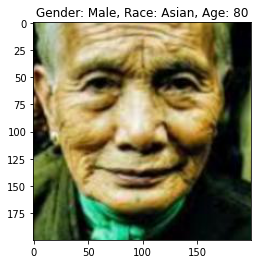

In [ ]:
row = df.iloc[np.random.randint(len(df))]
img = plt.imread(str(data_folder / row["img_name"]))
show_face(img, row["race"], row["gender"], row["age"])

Посмотрим на их распределение:

Counter({'White': 10078, 'Black': 4526, 'Indian': 3975, 'Asian': 3434, 'Others': 1692})
Counter({'Male': 12391, 'Female': 11314})


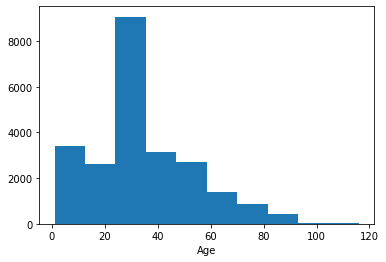

In [ ]:
races_verbose = [race_mapping[int(race)] for race in df["race"]]
genders_verbose = [gender_mapping[int(gender)] for gender in df["gender"]]
from collections import Counter
print(Counter(races_verbose))
print(Counter(genders_verbose))
_ = plt.hist(df["age"]*max_age)
_ = plt.xlabel("Age")

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def preprocess_input_facenet(image_):
    """
    image_ -- тензор размера (1, H, W, 3)
    
    return: картинка, с примененным preprocess_input(..., version=2) из keras_vggface (см пример с Бредом Питом)
    """
    # < YOUR CODE STARTS HERE >
    
    preprocessed = utils.preprocess_input(image_, version=2)
    
    # < YOUR CODE ENDS HERE >
    return preprocessed

# < YOUR CODE STARTS HERE >
# image_gen должен содержать ImageDataGenerator с правильной preprocessing_function

image_gen = ImageDataGenerator(preprocessing_function=preprocess_input_facenet)

# < YOUR CODE ENDS HERE >

Found 18946 validated image filenames belonging to 2 classes.
Found 4759 validated image filenames belonging to 2 classes.
Male


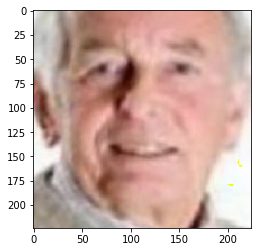

In [ ]:
def deprocess_image(vggface_image):
    """
    vggface_image -- (H, W, 3) картинка после препросессинга. 
    содержит отрицательные значения и некорректно отображается matplotlib

    return: корректно отображаеая картинка типа np.uint8(!!). 

    ! работайте с копией картинки (image = np.copy(vggface_image)) !
    """
    # < YOUR CODE STARTS HERE >
    
    image = np.copy(vggface_image)
    image[..., 0] += 93.5940    
    image[..., 1] += 104.7624    
    image[..., 2] += 129.1863
    image = image[..., ::-1].astype(np.uint8)

    # < YOUR CODE ENDS HERE >
    return image

# теперь картинка должна отображаться корректно

BATCH_SIZE = 128
IMAGE_SIZE = 224
# < YOUR CODE STARTS HERE >
# train_generator = image_gen.flow_from_dataframe( ... ), 
# val_generator = image_gen.flow_from_dataframe( ... )

train_generator = image_gen.flow_from_dataframe(df_train, directory=str(data_folder), 
                                                x_col='img_name', y_col='gender', 
                                                class_mode='binary',
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                shuffle=True)

val_generator = image_gen.flow_from_dataframe(df_val, directory=str(data_folder), 
                                                x_col='img_name', y_col='gender', 
                                                class_mode='binary',
                                                target_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                batch_size=BATCH_SIZE,
                                                shuffle=False)
sample_images, sample_labels = next(val_generator)
plt.imshow(deprocess_image(sample_images[101]))
print(gender_mapping[int(sample_labels[101])])

In [ ]:
!pip install livelossplot
from livelossplot.inputs.tf_keras import PlotLossesCallback

In [ ]:
#@title (вспомогательный код, выполните клетку)
def show_faces(images, real_race=None, real_gender=None, real_age=None, 
               predicted_race=None, predicted_gender=None, predicted_age=None):
    plt.figure(figsize=(10,10))
    labels = {"Gender": [predicted_gender, real_gender],
                  "Race": [predicted_race, real_race],
                  "Age": [predicted_age, real_age]}
    for i in range(16):
        plt.subplot(4,4, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(deprocess_image(images[i]))
        real_str = "Real:"
        pred_str = "Pred:"
        correct = True
        for name, (predicted, real) in labels.items():
            if predicted is None:
                continue
            if name == "Age":
                real_age = int(real[i]*int(max_age))
                predicted_age = int(predicted[i]*max_age)
                real_str += f"{real_age}"
                pred_str += f"{predicted_age}"
                if np.abs(predicted_age - real_age) > 6:
                    correct = False

            elif name == "Gender":
                real_gender = int(real[i])
                predicted_gender = int(predicted[i] > 0.5)
                real_str += f"{gender_mapping[real_gender]}, "
                pred_str += f"{gender_mapping[predicted_gender]}, "
                if real_gender != predicted_gender:
                    correct = False
            elif name == "Race":
                real_race = int(real[i])
                predicted_race = np.argmax(predicted[i])
                real_str += f"{race_mapping[real_race]}, "
                pred_str += f"{race_mapping[predicted_race]}, "
                if real_race != predicted_race:
                    correct = False
                
        title_obj = plt.title(f"{real_str}\n{pred_str}")
            
        plt.subplots_adjust(wspace=0.4)
        if not correct:
            plt.setp(title_obj, color='r')
        

## Задание 5. Multitask learning

В этом задании мы могли бы обучить регрессор возраста по картинке, используя аналогичный уже написаному код. Но вы пойдем по другому пути. 

Если на каждый атрибут (возраст, раса, пол) создавать одну модель, то таких моделей получится 3. Очевидно, что для предсказания на новой картике необходимо будет произвести инференс трех сетей. Это может быть ресурсо-затратно и сложнее в поддержке. 

Какой же есть еще подход? Он называется Multitask learning. Его идея в том, чтобы обучать одну модель для решения сразу нескольких задач! Гибкость нейронных сетей позволяет это сделать достаточно логичными образом. Необходимо вместо одной "головы" для предсказания сделать несколько. Таким образом в нашей задаче одна будет отвечать за классификацию пола (1 выход, вероятность), вторая -- за классификацию расы (5 выходов, вероятности) и третья -- за предсказания возраста (1 выход, число).

### a) 
**Реализуйте модель сети с тремя "головами".**

*    Вам нужно вспомнить что такое Functional API для определения моделей, потому что необходимо определить архитектуру с тремя выходами. С помощью Sequential API этого сделать нельзя.
*    За основу возьмите base_model (определена ниже), добавьте к ее выходу 1-2 полносвязных слоя (количество нейронов определите сами)
*    К последнему слою добавьте три паралельных выхода: два с одним нейроном и один с пятью
*    При определении выходных слоев обязательно укажите Dense(..., name="race"/"age"/"gender" )
*    Не забудьте про правильные активации. Т.к. возраст у нас нормирован (от 0 до 1), подумайте, какая активация ему подойдет
*    Порядок выходов модели: `outputs=[gender_output, race_output, age_output]`
*    Точность предсказания пола должна быть > 90%, расы > 80% а MAE для возраста < 0.09.

In [ ]:
#vggface_model = load_model("resnet50face.h5")
base_model = tf.keras.Model([vggface_model.input], vggface_model.get_layer("flatten_1").output)
base_model.trainable = False

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
functional_1 (Functional)       (None, 2048)         23561152    input_5[0][0]                    
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 32)           65568       functional_1[2][0]               
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 64)           2112        dense_4[0][0]                    
_______________________________________________________________________________________

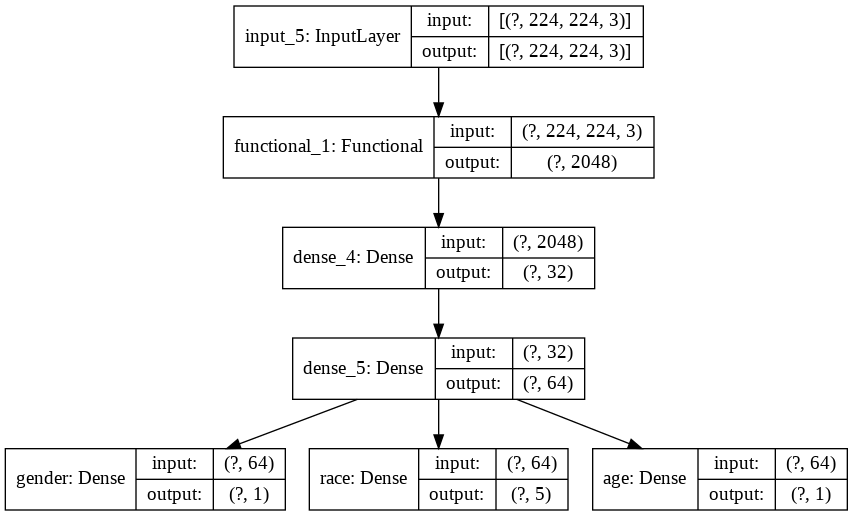

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import plot_model


input_layer = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# < YOUR CODE STARTS HERE >
# переменная model должна содержать модель для дальнейшего обучения

base_output = base_model(input_layer)
fc1 = tf.keras.layers.Dense(32, activation='relu')(base_output)
fc2 = tf.keras.layers.Dense(64, activation='relu')(fc1)
gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender')(fc2)
race_output = tf.keras.layers.Dense(5, activation='softmax', name='race')(fc2)
age_output = tf.keras.layers.Dense(1, name='age')(fc2) #activation='relu', 

model = tf.keras.Model(inputs=input_layer, outputs=[gender_output, race_output, age_output])


# < YOUR CODE ENDS HERE >
model.summary()
plot_model(model,show_shapes=True)


In [ ]:
prediction = model(np.zeros((6, IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32))
assert len(prediction) == 3, "Модель должна возвращать три тензора"
assert prediction[0].shape == (6, 1), f"Неправильный размер выхода gender: {prediction[0].shape}"
assert prediction[1].shape == (6, 5), f"Неправильный размер выхода race: {prediction[1].shape}"
assert prediction[2].shape == (6, 1), f"Неправильный размер выхода age: {prediction[2].shape}"
print("Shape tests passed")

Shape tests passed


Ниже мы приводим необходимые генераторы данных. Обратите внимание на y_col и class_mode.


In [ ]:
train_generator = image_gen.flow_from_dataframe(
        dataframe=df_train,
        class_mode="raw", # 'other'
        x_col="img_name", y_col=["gender", "race", "age"], # нас интересуют все три столбца
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=False)
def split_outputs(generator):
    """
    Вспомогательная функция, которая модернизирует генераторы картинок, чтобы их
    можно было использовать для Мultitask
    image_gen.flow_from_dataframe возвращает на каждой итерации батч:
    ((N, H, W, 3), (N, 3)) -- N картинок и N троек меток (для трех "задач")
    model.fit(..) ожидает генератор в формате:
    ((N, H, W, 3), [(N, 1), (N, 1), (N, 1)])

    Для такого превращения и нужна эта функция.

    """
    while True:
        data = next(generator)
        image = data[0]
        labels = np.split(data[1], 3, axis=1)
        yield image, {'gender':labels[0].astype(np.float32), 'race':labels[1].astype(np.float32), 'age':labels[2].astype(np.float32)}
        #[labels[i].astype(np.float32) for i in range(len(labels))] 
        #{'gender':labels[0].astype(np.float32), 'race':labels[1].astype(np.float32), 'age':labels[2].astype(np.float32)}

Found 18946 validated image filenames.
Found 4759 validated image filenames.


А теперь перейдем к обучению:

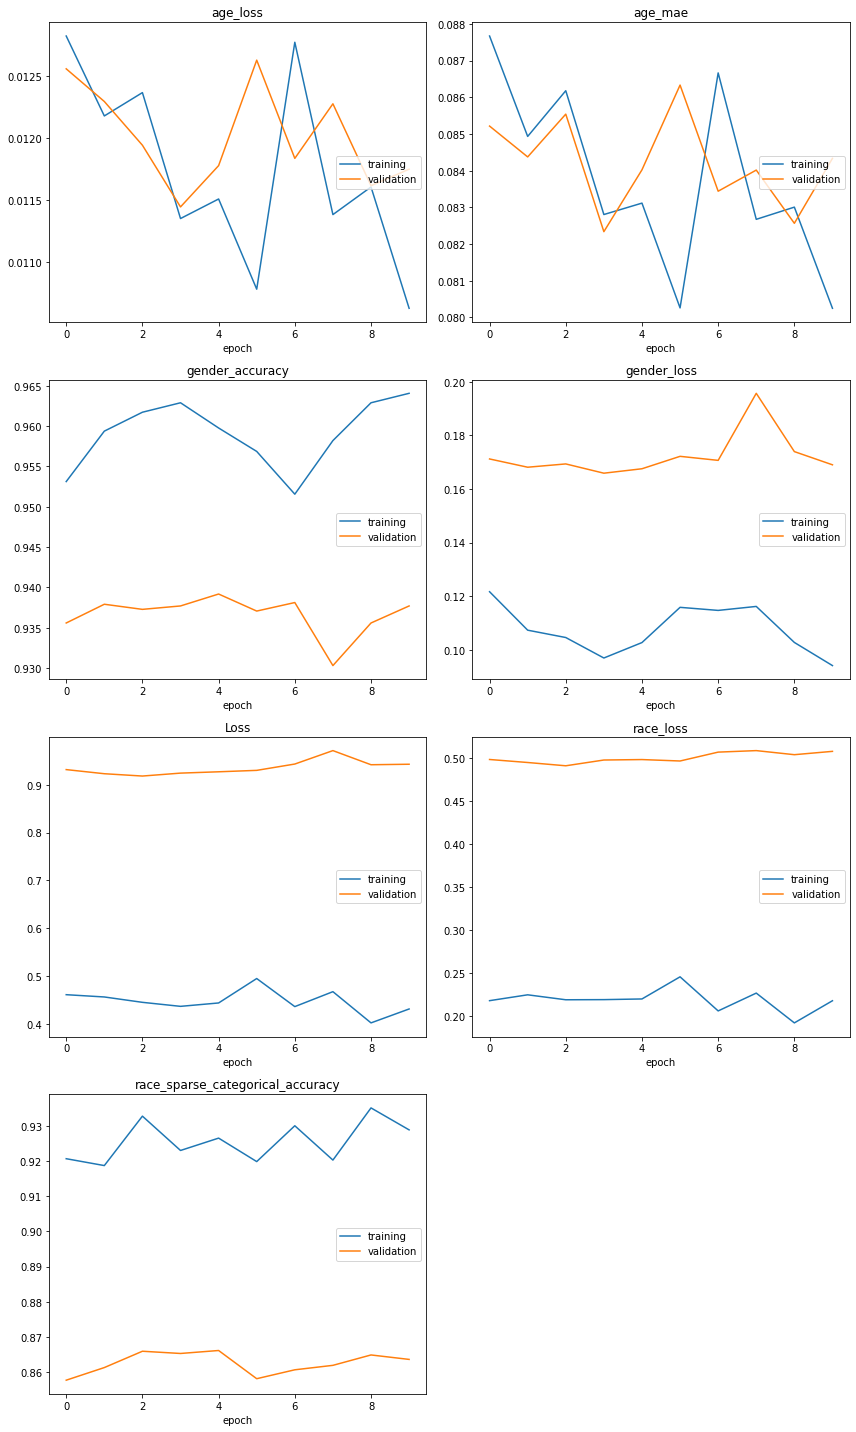

age_loss
	training         	 (min:    0.011, max:    0.013, cur:    0.011)
	validation       	 (min:    0.011, max:    0.013, cur:    0.012)
age_mae
	training         	 (min:    0.080, max:    0.088, cur:    0.080)
	validation       	 (min:    0.082, max:    0.086, cur:    0.084)
gender_accuracy
	training         	 (min:    0.952, max:    0.964, cur:    0.964)
	validation       	 (min:    0.930, max:    0.939, cur:    0.938)
gender_loss
	training         	 (min:    0.094, max:    0.122, cur:    0.094)
	validation       	 (min:    0.166, max:    0.196, cur:    0.169)
Loss
	training         	 (min:    0.402, max:    0.495, cur:    0.431)
	validation       	 (min:    0.918, max:    0.971, cur:    0.943)
race_loss
	training         	 (min:    0.192, max:    0.245, cur:    0.218)
	validation       	 (min:    0.491, max:    0.509, cur:    0.508)
race_sparse_categorical_accuracy
	training         	 (min:    0.919, max:    0.935, cur:    0.929)
	validation       	 (min:    0.858, max:    0.866

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005) # вы можете выбрать другую скорость обучения для вашей модели

# обратите внимание, что теперь loss -- это словарь, в котором к каждому выходу мы "прицепляем" свой лосс
# аналогично с metrics
model.compile(optimizer=optimizer, 
              loss={'gender': 'binary_crossentropy', 'race': 'sparse_categorical_crossentropy', 'age': 'mse'},
              metrics={'gender': 'accuracy', 'race': 'sparse_categorical_accuracy', 'age': 'mae'},
              loss_weights={'gender':1.0, 'race':1.5, 'age':1.0})

path = Path("model_multitask")
path.mkdir(exist_ok=True)
cpt_filename = "checkpoint_best.h5"
cpt_path =str(path / cpt_filename)

checkpoint = tf.keras.callbacks.ModelCheckpoint(cpt_path, monitor='val_age_mae', verbose=1, save_best_only=True, mode='min')

history = model.fit(x=split_outputs(train_generator), epochs=10, validation_data=split_outputs(val_generator),
          callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=20, validation_steps= len(df_val) // BATCH_SIZE)

# model.fit_generator(split_outputs(train_generator), epochs=15, validation_data=split_outputs(val_generator),
#                     callbacks=[PlotLossesCallback(), checkpoint], steps_per_epoch=50, 
#                     validation_steps= len(df_val) // BATCH_SIZE)

In [ ]:
model_multitask = load_model("model_multitask/checkpoint_best.h5")
val_generator = image_gen.flow_from_dataframe(
        dataframe=df_val,
        class_mode="raw",
        x_col="img_name", y_col=["gender", "race", "age"], 
        directory=str(data_folder),
        target_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        shuffle=True)
results = model.evaluate(split_outputs(val_generator), steps=len(df_val)//BATCH_SIZE)
assert results[-3] > 0.90, f"Gender accuracy is too low. Please try to improve it {results[-3]}"
assert results[-2] > 0.80, f"Race accuracy is too low. Please try to improve it. {results[-2]}"
assert results[-1] < 0.09, f"Age MAE it too high: {results[-1]}"
print("Well done!")

Found 4759 validated image filenames.
37/37 [==============================] - 9s 232ms/step - loss: 0.9388 - gender_loss: 0.1686 - race_loss: 0.5056 - age_loss: 0.0117 - gender_accuracy: 0.9379 - race_sparse_categorical_accuracy: 0.8640 - age_mae: 0.0842
Well done!


In [ ]:
results[-3:]

[0.9379222989082336, 0.8640202879905701, 0.08420556038618088]

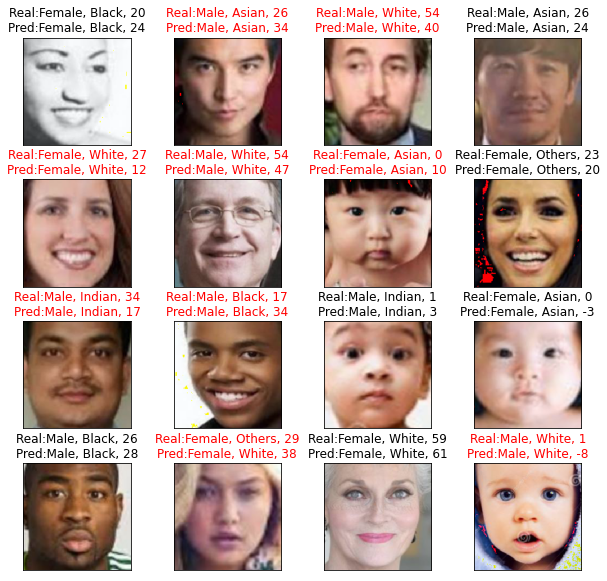

In [ ]:
sample_validation_images, sample_validation_labels = next(split_outputs(val_generator))
predicted = model_multitask.predict(sample_validation_images)
show_faces(sample_validation_images, 
           real_gender=sample_validation_labels['gender'], predicted_gender=predicted[0],
           real_race=sample_validation_labels['race'], predicted_race=predicted[1],
           real_age=sample_validation_labels['age'].flatten(), predicted_age=predicted[2].flatten(),
           )

###b)
Загрузите любое лицо и получите предсказание. Не забудьте его обрезать соответствующим образом. Результат сети не оценивается.

In [ ]:
url = 'https://drive.google.com/uc?id=1DNWOD2I64l0ivhhwGiVQK-KcmLAMVVbR'   

output = 'me.jpg'
gdown.download(url, output, quiet=False)

img = image.load_img("me.jpg", target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = utils.preprocess_input(x, version=2) 
predicted_labels = model.predict(x)
plt.imshow(img)
gender, race, age = int(predicted_labels[0][0] > 0.5), np.argmax(predicted_labels[1][0]), predicted_labels[2][0]
title_obj = f"Pred: {gender_mapping[gender]}, {race_mapping[race]}, {int(age[0]*max_age)}."
_ = plt.title(title_obj)
# я получился немного моложе :)

#Заключение 

Это было очень сложное и важное домашнее задание. Надеемся, вы с ним справились успешно и готовы к переходу к следующему модулю! Удачи!